## Comparing Foundation Models for Time Series Forecasting
### A hands-on evaluation of TimeGPT and Mimosa

Hey there! 👋 Ready to dive into some time series forecasting? In this notebook, we'll be putting two powerful foundation models head-to-head: Nixtla's TimeGPT and Sulie's Mimosa. Whether you're a data scientist, engineer, or just curious about forecasting, you'll find something interesting here.
The Business Challenge: Grocery Store Forecasting

Imagine yourself in the shoes of a Corporación Favorita store manager. You've got a complex challenge on your hands:
* You need to forecast sales for all products in your store
* The forecast horizon is 1 week
* Oh, and you need those forecasts by tomorrow! No pressure, right? 😅

This is exactly the kind of real-world scenario where foundation models can shine. Let's see how they perform!

In [149]:
import csv
import datetime
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from matplotlib.dates import DateFormatter

In [150]:
import logging

# Suppress INFO logs from nixtla.nixtla_client
logging.getLogger("nixtla.nixtla_client").setLevel(logging.WARNING)

## 📚 Our Dataset

We're working with a fascinating dataset that tracks daily sales for approximately 3,500 different products. Here's what makes it interesting:

* Source: The data is derived from a larger dataset available [here](https://github.com/MMenchero/timegpt_latinr)
* Sampling strategy: We've carefully selected data from the top and bottom 25 stores by sales volume.
* Goal: Predict future demand across this diverse product range

In [130]:
filepath = "./datasets/corporacion-favorita-store/data.csv"
df = pd.read_csv(filepath)

# Cast the datetime column to Python native type
df["ds"] = pd.to_datetime(df["ds"])

df.head()

,unique_id,ds,y
0,159156,2013-01-02,245.751
1,159156,2013-01-03,198.578
2,159156,2013-01-04,211.843
3,159156,2013-01-05,209.376
4,159156,2013-01-06,291.602


Next, let's vizualize the sales data by randomly sampling a number of different products. We have set the sample size `k` to `10`, but feel free to change that.

In [133]:
random_product_ids = random.sample([*{product_id for product_id in df["unique_id"].values}], k=10)

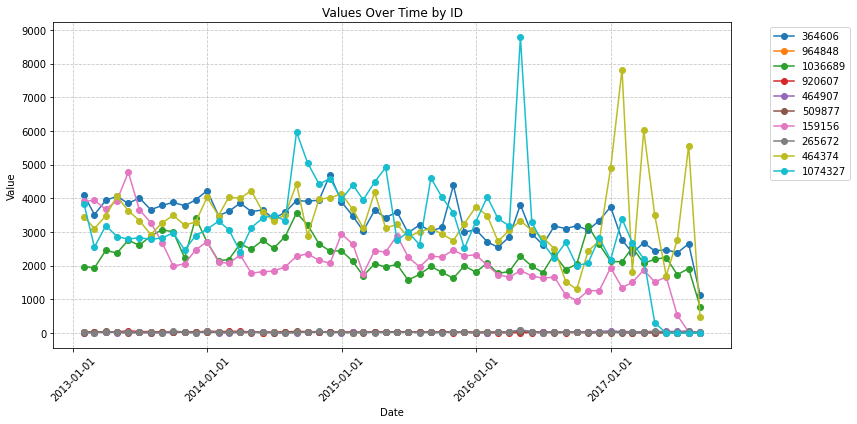

In [134]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each group
for product_id in random_product_ids:
    
    # Filter for this product and resample to monthly
    group_sales_data = df[df["unique_id"] == product_id]
    
    # Group sales data by month just for vizualization purposes
    monthly_group = group_sales_data\
        .groupby(pd.Grouper(key="ds", freq="ME"))["y"]\
        .sum()\
        .reset_index()
    
    ax.plot(
        monthly_group["ds"], 
        monthly_group["y"],
        marker="o", # Add points at each data point
        label=str(product_id),
        linestyle="-",
        markersize=6
    )

# Customize the plot
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.set_title("Values Over Time by ID")

# Format dates on x-axis
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

# Force y-axis to use integer ticks
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add grid
ax.grid(True, linestyle="--", alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

To create our test dataset, we'll select products from both ends of the sales spectrum - including both top performers and products with minimal sales. For each selected product, we'll use the last 168 days of data for our predictions, ensuring a consistent evaluation window across all items. This approach lets us assess how well our models handle both high-volume and low-volume forecasting scenarios.

In [153]:
test = df.groupby("unique_id", group_keys=False)\
    .apply(lambda x: x.nlargest(168, "ds"))\
    .reset_index(drop=True)

test.head()

<ipython-input-153-625c19781c61>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = df.groupby("unique_id", group_keys=False)\


,unique_id,ds,y
0,159156,2017-08-15,0.000
1,159156,2017-08-14,2.554
2,159156,2017-08-13,0.000
3,159156,2017-08-12,0.000
4,159156,2017-08-11,0.000


## The Contenders

### TimeGPT by Nixtla

TimeGPT is a zero-shot forecasting powerhouse that's making waves in the time series community. Some key features:
* Pretrained on millions of time series
* Zero-shot capabilities mean no retraining needed
* Handles multiple seasonalities
* Built-in support for various forecasting scenarios

In [154]:
from nixtla import NixtlaClient

In [155]:
nixtla_client = NixtlaClient(
    api_key=os.environ.get("NIXTLA_API_KEY")
)

Make predictions across a sliding day window.

In [156]:
# Sliding window in terms of number of days to forecast for
sliding_window = 7

In [157]:
timegpt_preds = []

for unique_id in pd.unique(df['unique_id']):
    for i in range(0, 162, sliding_window):
        
        # Filter data for product and move time horizon
        sales_data_for_range = test[test["unique_id"] == unique_id].iloc[:1519+i]
        
        # Call the zero-shot forecasting API endpoint
        timegpt_preds_df = nixtla_client.forecast(
            df=sales_data_for_range,
            h=sliding_window,
            id_col='unique_id',
            time_col='ds',
            target_col='y'
        )
        timegpt_preds.extend(timegpt_preds_df['TimeGPT'])

In [159]:
# Set the TimeGPT generated forecasts
test["TimeGPT"] = timegpt_preds

In [160]:
test.head()

,unique_id,ds,y,TimeGPT
0,159156,2017-08-15,0.000,0.419042
1,159156,2017-08-14,2.554,0.463206
2,159156,2017-08-13,0.000,0.511554
3,159156,2017-08-12,0.000,0.596689
4,159156,2017-08-11,0.000,0.560084


## 🔥 Mimosa by Sulie
Meet Mimosa, Sulie's contribution to the forecasting world. This model brings some impressive capabilities:

* Transformer-based architecture with self-attention mechanisms
* Zero-shot forecasting capabilities
* Built-in MLOps handling

Want to learn more? Check out Sulie's [website](https://sulie.co).

In [161]:
from sulie import Sulie

In [162]:
sulie_client = Sulie(
    api_key=os.environ.get("SULIE_API_KEY")
)

In [164]:
sulie_preds = []


for unique_id in pd.unique(df['unique_id']):
    for i in range(0, 162, sliding_window):
        
        # Filter data for product and move time horizon
        sales_data_for_range = test[test["unique_id"] == unique_id].iloc[:1519+i]
        
        # Call the zero-shot forecasting API endpoint
        low, median, high = sulie_client.forecast(
            dataset=sales_data_for_range,
            horizon=sliding_window,
            target='y'
        )
        sulie_preds.extend(median)

In [169]:
# Set the TimeGPT generated forecasts
test["Sulie"] = sulie_preds

In [170]:
test.head()

,unique_id,ds,y,TimeGPT,Sulie
0,159156,2017-08-15,0.000,0.419042,51.511112
1,159156,2017-08-14,2.554,0.463206,66.473866
2,159156,2017-08-13,0.000,0.511554,82.295139
3,159156,2017-08-12,0.000,0.596689,64.879475
4,159156,2017-08-11,0.000,0.560084,67.332386


## Evaluation Methodology
We're using Mean Absolute Error (MAE) to evaluate our models. Here's why MAE is particularly useful:

* Interpretability: MAE is straightforward to understand - it's the average magnitude of errors in units of the forecast variable.
* Robustness: Less sensitive to outliers compared to squared error metrics.
* Business Relevance: In retail, knowing the average error in units directly translates to inventory planning.

In [171]:
import numpy as np

def calculate_mae(actuals: np.ndarray, forecasts: np.ndarray) -> float:
    """
    Calculate the Mean Absolute Error (MAE) between actual and forecasted values.
    
    Args:
        actuals (np.ndarray): The actual observed values.
        forecasts (np.ndarray): The forecasted values.
        
    Returns:
        float: The Mean Absolute Error (MAE).
    """
    # Calculate the absolute errors
    absolute_errors = np.abs(actuals - forecasts)
    
    # Compute the mean of the absolute errors
    mae = np.mean(absolute_errors)
    
    return mae

MAE is calculated for each product individually. A final MAE is calculated as the median accross all groups.

In [172]:
sulie_mae, timegpt_mae = [], []

# Traverse through each product separately
for identifier, group in test.groupby("unique_id"):
    
    mae = calculate_mae(group["y"], group["TimeGPT"])
    timegpt_mae.append(mae)

    mae = calculate_mae(group["y"], group["Sulie"])
    sulie_mae.append(mae)

Vizualize the scores for each model and group.

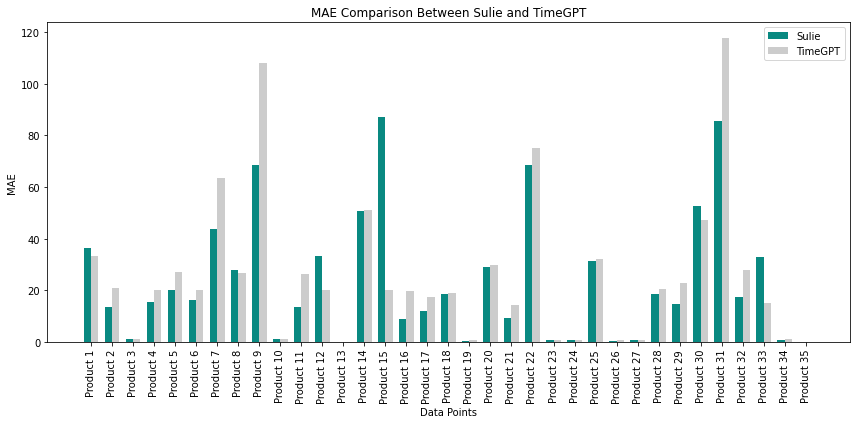

In [178]:
# Indices for x-axis
x = np.arange(len(sulie_mae))

# Bar width
width = 0.35

# Create plot
plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, sulie_mae, width, label="Sulie", color="#098981")
plt.bar(x + width / 2, timegpt_mae, width, label="TimeGPT", color="#CCCCCC")

# Labels and title
plt.xlabel("Data Points")
plt.ylabel("MAE")
plt.title("MAE Comparison Between Sulie and TimeGPT")
plt.xticks(ticks=x, labels=[f"Product {i+1}" for i in range(len(sulie_mae))], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

Display the global and median MAE for both models. 

In [185]:
sulie_median_mae = np.median(sulie_mae)
timegpt_median_mae = np.median(timegpt_mae)

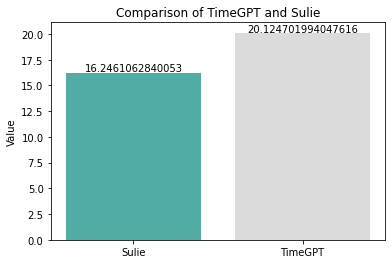

In [186]:
# Data
labels = ["Sulie", "TimeGPT"] 
values = [sulie_median_mae, timegpt_median_mae]

# Create bar chart
plt.bar(labels, values, color=["#098981", "#CCCCCC"], alpha=0.7)

# Add labels and title
plt.ylabel("Value")
plt.title("Comparison of TimeGPT and Sulie")

# Display values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha="center", fontsize=10)

# Show plot
plt.show()

Randomly pick a product and vizualize sales forecasts for both models vs. the actual data.

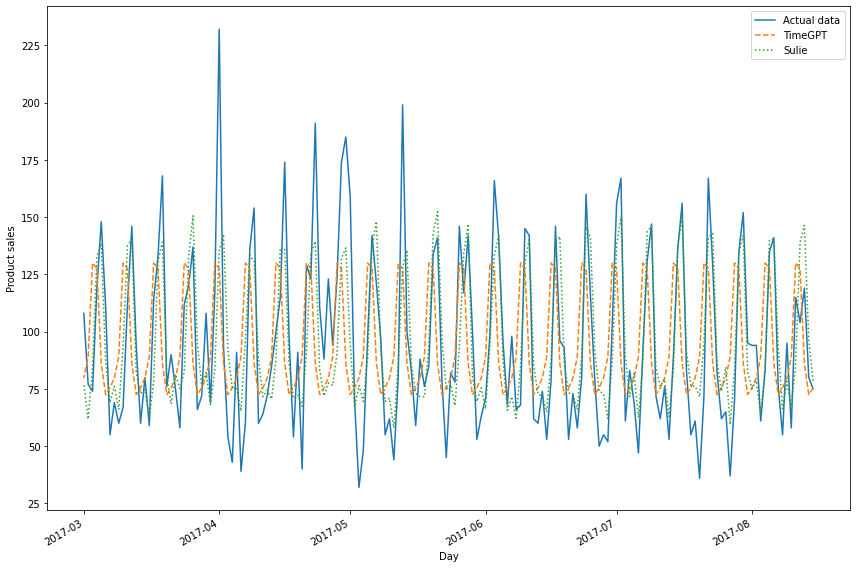

In [184]:
# Randomly choose product
unique_id = random.choice(test["unique_id"].unique())

# Select data only specific to chosen product
demand_for_group = test[test["unique_id"] == unique_id]

# Create plot
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(demand_for_group["ds"], demand_for_group["y"], label="Actual data")
ax.plot(demand_for_group["ds"], demand_for_group["TimeGPT"], ls="--", label="TimeGPT")
ax.plot(demand_for_group["ds"], demand_for_group["Sulie"], ls=":", label="Sulie")

ax.set_xlabel("Day")
ax.set_ylabel("Product sales")
ax.legend(loc="best")

fig.autofmt_xdate()

plt.tight_layout()